In [1]:
#example of loading the mnist dataset
from keras.datasets.mnist import load_data
#load the images into memory
(train_x,train_y),(test_x,test_y)=load_data()
#summarize the shape of the dataset
print('Train',train_x.shape,train_y.shape)
print('Test',test_x.shape,test_y.shape)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

11490434/11490434 [==============================] - 1s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Running the examples create a plot of 25 images from the MNIST dataset, arranged in a 5x5 square. We will use the images in the training dataset as the basis for training a Generative Adversarial Network(GAN). Specifically, the generator model learn how to generate new plausible handwritten digits between 0 and 9, using a discriminator that will try to distinguish between real images from the MNIST training dataset and new images output by the generator model. This is a relatively simple problem that does not require a sophisticated generator or discriminator model, although it does require the generation of a grayscale output image.

# How to define and train the Discriminator model

first step is to define the discriminator model. The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake. 

- **Inputs:** Image with one channel and 28x28 pixels.
- **Outputs:** Binary classification, likelihood the sample is real (or fake).

The discriminator model has two convolutional layers with 64 filters each, a small kernel size of 3, and larger than normal stride of 2. The model has no pooling layers and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the binary cross-entropy loss function, appropriate for binary classification. We will use some best practices in  defining the discriminator model, such as the use of `LeakyReLU` instead of `ReLU`, using `Dropout` and using the `Adam` version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5. The function `define_discriminator()` below defines the discriminator model and parametrizes the size of the input image.

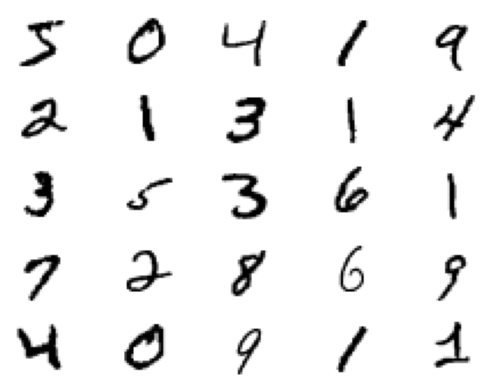

In [3]:
#plot images from the training dataset
for i in range(25):
    #define subplot
    plt.subplot(5,5,1+i)
    #turn off axis
    plt.axis('off')
    #plot the raw pixel data
    plt.imshow(train_x[i],cmap='gray_r')
plt.show()

# Defining the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

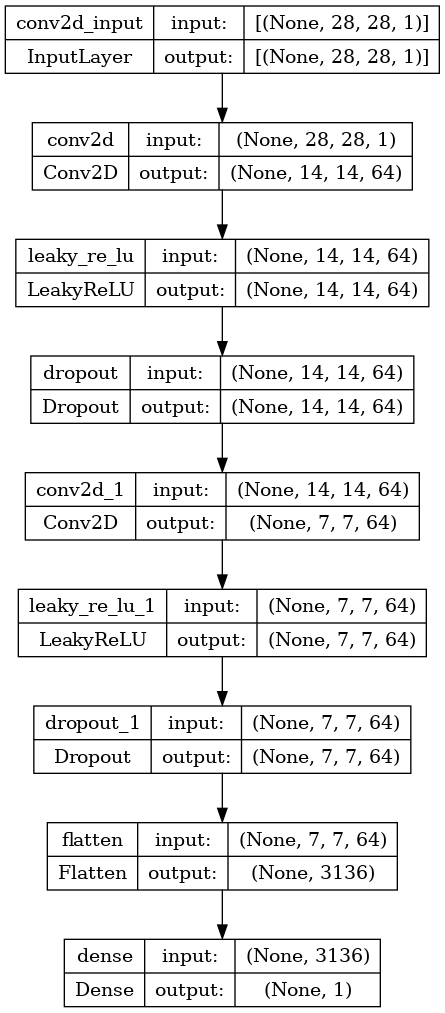

In [4]:
#example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint

#define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model=Sequential()
    model.add(Conv2D(64,(3,3),strides=(2,2),padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    #compile model
    opt=Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model
#define model
model=define_discriminator()
#summarize the model
model.summary()
#plot the model
plot_model(model,to_file='discriminator_plot.png',show_shapes=True,show_layer_names=True)

# function for loading and preparing the MNIST dataset

We could start training this model now with real examples with a class label of one, and
randomly generated samples with a class label of zero. The development of these elements will
be useful later, and it helps to see that the discriminator is just a normal neural network model
for binary classification. First, we need a function to load and prepare the dataset of real images.
We will use the `mnist.load_data()` function to load the MNIST dataset and just use the input
part of the training dataset as the real images.

The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of
images as input, where each image has one or more channels We must update the images to have
an additional dimension for the grayscale channel. We can do this using the `expand_dims()`
NumPy function and specify the final dimension for the channels-last image format.

Finally, we must scale the pixel values from the range of unsigned integers in [0,255] to the
normalized range of [0,1]. It is best practice to use the range [-1,1], but in this case the range
[0,1] works just fine.

In [5]:
#load and prepare the mnist training images
def load_real_samples():
    #load mnist dataset
    (train_x,_),(_,_)=load_data()
    #expand to 3d,e.g. add channels dimension
    x=expand_dims(train_x,axis=-1)
    #convert from unsigned ints to floats
    x=x.astype('float32')
    #scale from [0,255] to [0,1]
    x=x/255.0
    return x

The model will be updated in batches, specifically with a collection of real samples and a
collection of generated samples. On training, an epoch is defined as one pass through the entire
training dataset. We could systematically enumerate all samples in the training dataset, and
that is a good approach, but good training via stochastic gradient descent requires that the
training dataset be shuffled prior to each epoch. A simpler approach is to select random samples
of images from the training dataset. The `generate_real_samples()` function below will take
the training dataset as an argument and will select a random subsample of images; it will also
return class labels for the sample, specifically a class label of 1, to indicate real images.

In [6]:
#generate real sample
def generate_real_samples(dataset,n_samples):
    #choose random instances
    ix=randint(0,dataset.shape[0],n_samples)
    #retrieve selected images
    x=dataset[ix]
    #generated 'real' class labels (1)
    y=ones((n_samples,1))
    return x,y

Now, we need a source of fake images. We don’t have a generator model yet, so instead,
we can generate images comprised of random pixel values, specifically random pixel values
in the range [0,1] like our scaled real images. The generate_fake_samples() function below
implements this behavior and generates images of random pixel values and their associated class
label of 0, for fake.


In [7]:
#generate n fake samples with class labels
def generate_fake_samples(n_samples):
    #generate uniform random numbers in [0,1]
    x=rand(28*28*n_samples)
    #reshape into a batch of grayscale images
    x=x.reshape((n_samples,28,28,1))
    #generate 'fake' class labels (0)
    y=zeros((n_samples,1))
    return x,y

Finally, we need to train the discriminator model. This involves repeatedly retrieving samples
of real images and samples of generated images and updating the model for a fixed number of
iterations. We will ignore the idea of epochs for now (e.g. complete passes through the training
dataset) and fit the discriminator model for a fixed number of batches. The model will learn to
discriminate between real and fake (randomly generated) images rapidly, therefore, not many
batches will be required before it learns to discriminate perfectly.
The `train_discriminator()` function implements this, using a batch size of 256 images
where 128 are real and 128 are fake each iteration. We update the discriminator separately for
real and fake examples so that we can calculate the accuracy of the model on each sample prior
to the update. This gives insight into how the discriminator model is performing over time.

In [8]:
#train the discriminator model
def train_discriminator(model,dataset,n_iter=100,n_batch=256):
    half_batch=int(n_batch/2)
    #manually enumerate epochs
    for i in range(n_iter):
        #get randomly selected 'real' samples
        x_real,y_real=generate_real_samples(dataset,half_batch)
        #update discriminator on real samples
        _,real_acc=model.train_on_batch(x_real,y_real)
        #generate 'fake' samples
        x_fake,y_fake=generate_fake_samples(half_batch)
        #update discriminator on fake samples
        _,fake_acc=model.train_on_batch(x_fake,y_fake)
        #summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1,real_acc*100,fake_acc*100))

Running the example first defines the model, loads the MNIST dataset, then trains the
discriminator model.


In [9]:
#define the discriminator model
# model=define_discriminator()
#load image data
dataset=load_real_samples()
#fit the model
train_discriminator(model,dataset)

2023-06-05 10:22:28.591157: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


>1 real=48% fake=23%
>2 real=71% fake=42%
>3 real=66% fake=55%
>4 real=72% fake=78%
>5 real=72% fake=88%
>6 real=68% fake=94%
>7 real=70% fake=98%
>8 real=72% fake=99%
>9 real=74% fake=100%
>10 real=73% fake=100%
>11 real=68% fake=100%
>12 real=82% fake=100%
>13 real=81% fake=100%
>14 real=87% fake=100%
>15 real=84% fake=100%
>16 real=78% fake=100%
>17 real=77% fake=100%
>18 real=84% fake=100%
>19 real=91% fake=100%
>20 real=92% fake=100%
>21 real=93% fake=100%
>22 real=90% fake=100%
>23 real=94% fake=100%
>24 real=92% fake=100%
>25 real=96% fake=100%
>26 real=97% fake=100%
>27 real=97% fake=100%
>28 real=97% fake=100%
>29 real=96% fake=100%
>30 real=99% fake=100%
>31 real=98% fake=100%
>32 real=98% fake=100%
>33 real=100% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fak

# How to Define and use the Generator model

The generator model is responsible for creating new, fake but plausible images of handwritten
digits. It does this by taking a point from the latent space as input and outputting a square grayscale image. The latent space is an arbitrarily defined vector space of Gaussian-distributed
values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly
and providing them to the generator model during training, the generator model will assign
meaning to the latent points. At the end of training, the latent vector space represents a
compressed representation of the output space, MNIST images, that only the generator knows
how to turn into plausible MNIST images.

- **Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
- **Outputs**: Two-dimensional square grayscale image of 28 × 28 pixels with pixel values in
[0,1].

We don’t have to use a 100 element vector as input; it is a round number and widely used,
but I would expect that 10, 50, or 500 would work just as well. Developing a generator model
requires that we transform a vector from the latent space with, 100 dimensions to a 2D array
with 28×28 or 784 values. There are a number of ways to achieve this but there is one approach
that has proven effective at deep convolutional generative adversarial networks. It involves two
main elements. The first is a `Dense` layer as the first hidden layer that has enough nodes to
represent a low-resolution version of the output image. Specifically, an image half the size (one
quarter the area) of the output image would be 14 × 14 or 196 nodes, and an image one quarter
the size (one eighth the area) would be 7 × 7 or 49 nodes.
We don’t just want one low-resolution version of the image; we want many parallel versions
or interpretations of the input. This is a pattern in convolutional neural networks where we
have many parallel filters resulting in multiple parallel activation maps, called feature maps,
with different interpretations of the input. We want the same thing in reverse: many parallel
versions of our output with different learned features that can be collapsed in the output layer
into a final image. The model needs space to invent, create, or generate. Therefore, the first
hidden layer, the Dense layer needs enough nodes for multiple low-resolution versions of our
output image, such as 128.

The next major architectural innovation involves upsampling the low-resolution image to
a higher resolution version of the image. There are two common ways to do this upsampling
process, sometimes called deconvolution. One way is to use an `UpSampling2D` layer (like a
reverse pooling layer) followed by a normal `Conv2D` layer. The other and perhaps more modern
way is to combine these two operations into a single layer, called a `Conv2DTranspose`. We will
use this latter approach for our generator.
The `Conv2DTranspose` layer can be configured with a stride of (2 × 2) that will quadruple
the area of the input feature maps (double their width and height dimensions). It is also good
practice to use a kernel size that is a factor of the stride (e.g. double) to avoid a checkerboard pattern that can be observed when upsampling 
This can be repeated to arrive at our 28×28 output image. Again, we will use the `LeakyReLU`
activation with a default slope of 0.2, reported as a best practice when training GAN models.
The output layer of the model is a `Conv2D` with one filter and a kernel size of 7 × 7 and "‘same’" padding, designed to create a single feature map and preserve its dimensions at 28 × 28 pixels. A sigmoid activation is used to ensure output values are in the desired range of [0,1]. The define_generator() function below implements this and defines the generator model. The
generator model is not compiled and does not specify a loss function or optimization algorithm.
This is because the generator is not trained directly.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

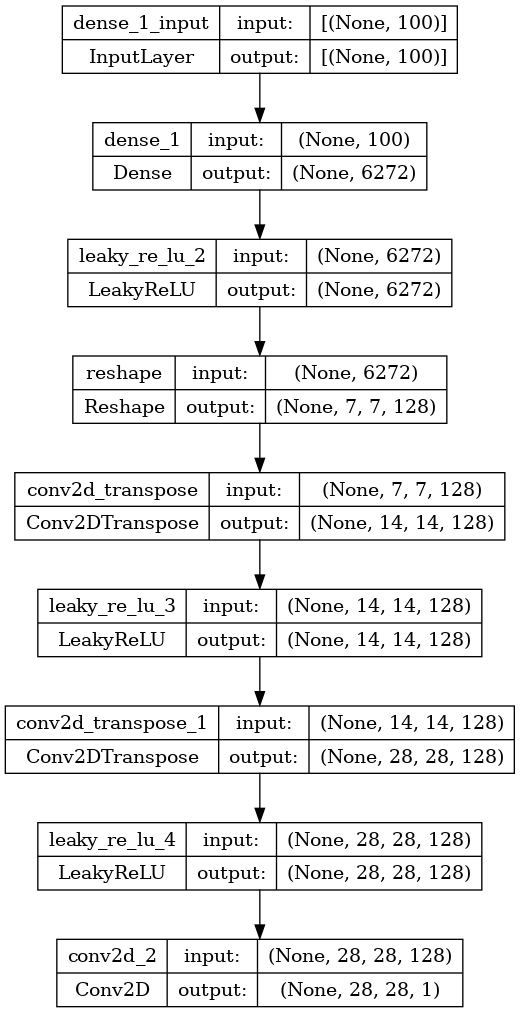

In [10]:
#examples of defining the generator model
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

#define the standalone generator model
def define_generator(latent_dim):
    model=Sequential()
    #foundation for 7x7 image
    n_nodes=128*7*7
    model.add(Dense(n_nodes,input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    #upsample to 14x14
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upsample to 28x28
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1,(7,7),activation='sigmoid',padding='same'))
    return model
#define the size of the latent space
latent_dim=100
#define the generator model
model=define_generator(latent_dim)
#summarize the model
model.summary()
#plot the model
plot_model(model,to_file='generator_plot.png',show_shapes=True,show_layer_names=True)

This model cannot do much at the moment. Nevertheless, we can demonstrate how to use
it to generate samples. This is a helpful demonstration to understand the generator as just
another model, and some of these elements will be useful later. The first step is to draw new points from the latent space. We can achieve this by calling the `randn()` NumPy function for
generating arrays of random numbers drawn from a standard Gaussian. The array of random
numbers can then be reshaped into samples, that is n rows with 100 elements per row. The
`generate_latent_points()` function below implements this and generates the desired number
of points in the latent space that can be used as input to the generator model.

Next, we can use the generated points as input to the generator model to generate new
samples, then plot the samples. We can update the `generate_fake_samples()` function from
the previous section to take the generator model as an argument and use it to generate
the desired number of samples by first calling the `generate_latent_points()` function to
generate the required number of points in latent space as input to the model. The updated
`generate_fake_samples()` function is listed below and returns both the generated samples and
the associated class labels.


1/1 [==============================] - 0s 186ms/step


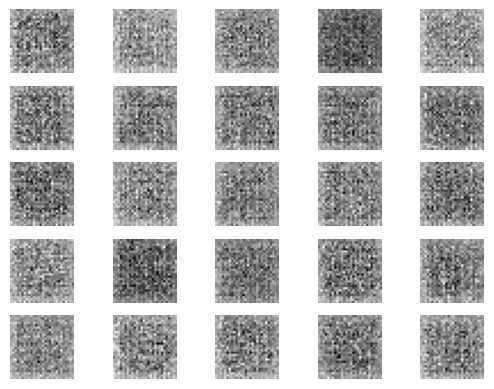

In [11]:
#generate points in latent space as input for the generator
def generate_latent_points(latent_dim,n_samples):
    #generate points in the latent space
    x_input=randn(latent_dim*n_samples)
    #reshape into a batch of inputs for the network
    x_input=x_input.reshape(n_samples,latent_dim)
    return x_input
#use the generator to generate n fake examples, with class tables
def generate_fake_samples(g_model,latent_dim,n_samples):
    #generate points in the latent space
    x_input=generate_latent_points(latent_dim,n_samples)
    #predict outputs
    x=g_model.predict(x_input)
    #create 'fake' class labels (0)
    y=zeros((n_samples,1))
    return x,y
#generate_samples
n_samples=25
x,_=generate_fake_samples(model,latent_dim,n_samples)
#plot the generated samples
for i in range(n_samples):
    #define subplot
    plt.subplot(5,5,1+i)
    #turn off axis labels
    plt.axis('off')
    #plot single image
    plt.imshow(x[i,:,:,0],cmap='gray_r')
#show the figure
plt.show()

# How to train the Generator model?

The weights in the generator model are updated based on the performance of the discriminator
model. When the discriminator is good at detecting fake samples, the generator is updated more,
and when the discriminator model is relatively poor or confused when detecting fake samples,
the generator model is updated less. This defines the zero-sum or adversarial relationship
between these two models. There may be many ways to implement this using the Keras API,
but perhaps the simplest approach is to create a new model that combines the generator and
discriminator models. Specifically, a new GAN model can be defined that stacks the generator
and discriminator such that the generator receives as input random points in the latent space
and generates samples that are fed into the discriminator model directly, classified, and the
output of this larger model can be used to update the model weights of the generator.
  To be clear, we are not talking about a new third model, just a new logical model that
uses the already-defined layers and weights from the standalone generator and discriminator
models. Only the discriminator is concerned with distinguishing between real and fake examples,
therefore the discriminator model can be trained in a standalone manner on examples of each, as we did in the section on the discriminator model above. The generator model is only concerned
with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers
in the discriminator as not trainable when it is part of the GAN model so that they cannot
be updated and overtrained on fake examples. When training the generator via this logical
GAN model, there is one more important change. We want the discriminator to think that the
samples output by the generator are real, not fake. Therefore, when the generator is trained as
part of the GAN model, we will mark the generated samples as real (class = 1).

**Why would we want to do this?** We can imagine that the discriminator will then classify
the generated samples as not real (class = 0) or a low probability of being real (0.3 or 0.5). The
backpropagation process used to update the model weights will see this as a large error and will
update the model weights (i.e. only the weights in the generator) to correct for this error, in
turn making the generator better at generating good fake samples. Let’s make this concrete.

• **Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.

• **Outputs**: Binary classification, likelihood the sample is real (or fake).

The `define_gan()` function below takes as arguments the already-defined generator and
discriminator models and creates the new logical third model subsuming these two models. The
weights in the discriminator are marked as not trainable, which only affects the weights as seen
by the GAN model and not the standalone discriminator model. The GAN model then uses the
same binary cross-entropy loss function as the discriminator and the efficient Adam version of
stochastic gradient descent with the learning rate of 0.0002 and momentum 0.5, recommended
when training deep convolutional GANs.


Making the discriminator not trainable is a clever trick in the Keras API. The trainable
property impacts the model after it is compiled. The discriminator model was compiled with
trainable layers, therefore the model weights in those layers will be updated when the standalone
model is updated via calls to the `train_on_batch()` function. The discriminator model was
then marked as not trainable, added to the GAN model, and compiled. In this model, the model
weights of the discriminator model are not trainable and cannot be changed when the GAN
model is updated via calls to the `train_on_batch()` function. This change in the trainable
property does not impact the training of standalone discriminator model. The complete example
of creating the discriminator, generator, and composite model is listed below

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


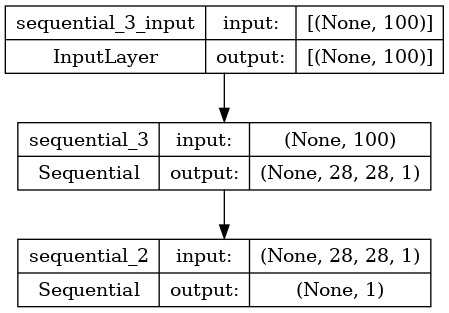

In [12]:
#define the standalone discriminator model
def define_gan(g_model,d_model):
    #make weights in the discriminator not trainable
    d_model.trainable=False
    #connect them
    model=Sequential()
    #add generator
    model.add(g_model)
    #add the discriminator
    model.add(d_model)
    #compile model
    opt=Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model
#create the discriminator
d_model=define_discriminator()
#create the generator
g_model=define_generator(latent_dim)
#create the gan
gan_model=define_gan(g_model,d_model)
#summarize gan model
gan_model.summary()
#plot gan model
plot_model(gan_model,to_file='gan_plot.png',show_shapes=True,show_layer_names=True)

Training the composite model involves generating a batch worth of points in the latent
space via the `generate_latent_points()` function in the previous section, and class = 1 labels
and calling the `train_on_batch()` function. The `train_gan()` function below demonstrates
this, although it is pretty simple as only the generator will be updated each epoch, leaving the
discriminator with default model weights.

Instead, what is required is that we first update the discriminator model with real and fake
samples, then update the generator via the composite model. This requires combining elements
from the `train_discriminator()` function defined in the discriminator section above and the
`train_gan()` function defined above. It also requires that we enumerate over both epochs and
batches within in an epoch. The complete train function for updating the discriminator model
and the generator (via the composite model) is listed below. There are a few things to note
in this model training function. First, the number of batches within an epoch is defined by
how many times the batch size divides into the training dataset. We have a dataset size of
60K samples and a batch size of 256, so with rounding down, there are 60000
256 or 234 batches per epoch.

The discriminator model is updated once per batch by combining one half a batch (128)
of fake and real (128) examples into a single batch via the `vstack()` NumPy function. You
could update the discriminator with each half batch separately (recommended for more complex
datasets) but combining the samples into a single batch will be faster over a long run, especially when training on GPU hardware. Finally, we report the loss for each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate. Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch on this dataset. The generator loss is less critical and may hover between 0.5 and 2 or higher on this dataset. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.


In [13]:
#train the generator and discriminator
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=100,n_batch=256):
    bat_per_epo=int(dataset.shape[0]/n_batch)
    half_batch=int(n_batch/2)
    #manually enumerate epochs
    for i in range(n_epochs):
        #enumerate batches over the training set 
        for j in range(bat_per_epo):
            #get randomly selected 'real' samples
            x_real,y_real=generate_real_samples(dataset,half_batch)
            #generate 'fake' examples
            x_fake,y_fake=generate_fake_example(g_model,latent_dim,half_batch)
            #create training set for the discriminator
            x,y=vstack((x_real,x_fake)),vstack((y_real,y_fake))
            #update discriminator model weights
            d_loss,_=d_model.train_on_batch(x,y)
            #prepare points in latent space as input for the generator
            x_gan=generate_latent_points(latent_dim,n_batch)
            #create inverted labels for the fake samples
            y_gan=ones((n_batch,1))
            #update the generator via the discriminator's error
            g_loss=gan_model.train_on_batch(x_gan,y_gan)
            #summarize the loss on this batch
            print('>%d,%d%d,d=%.3f,g=%.3f' % (i+1,j+1,bat_per_epo,d_loss,g_loss))

# How to evaluate GAN model performance

Generally, there are no objective ways to evaluate the performance of a GAN model. We cannot
calculate this objective error score for generated images. It might be possible in the case of
MNIST images because the images are so well constrained, but in general, it is not possible (yet).
Instead, images must be subjectively evaluated for quality by a human operator. This means
that we cannot know when to stop training without looking at examples of generated images. In
turn, the adversarial nature of the training process means that the generator is changing after
every batch, meaning that once good enough images can be generated, the subjective quality of
the images may then begin to vary, improve, or even degrade with subsequent updates. There
are three ways to handle this complex training situation.
1. Periodically evaluate the classification accuracy of the discriminator on real and fake
   images.
   
2. Periodically generate many images and save them to file for subjective review.

3. Periodically save the generator model.

All three of these actions can be performed at the same time for a given training epoch, such
as every five or 10 training epochs. The result will be a saved generator model for which we have
a way of subjectively assessing the quality of its output and objectively knowing how well the
discriminator was fooled at the time the model was saved. Training the GAN over many epochs,
such as hundreds or thousands of epochs, will result in many snapshots of the model that can
be inspected and from which specific outputs and models can be cherry-picked for later use.
  First, we can define a function called `summarize_performance()` that will summarize the
performance of the discriminator model. It does this by retrieving a sample of real MNIST
images, as well as generating the same number of fake MNIST images with the generator model,
then evaluating the classification accuracy of the discriminator model on each sample and
reporting these scores.

In [14]:
from numpy import vstack

In [15]:
#create and save a plot of generated images (reversed grayscale)
def save_plot(examples,epoch,n=10):
    #plot images
    for i in range(n*n):
        #define subplot
        plt.subplot(n,n,1+i)
        #turn off axis
        plt.axis('off')
        #plot raw pixel data
        plt.imshow(examples[i,:,:,0],cmap='gray_r')
        #save plot to file
        filename='generated_plot_e%03d.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
#evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=100):
    #prepare real samples
    x_real,y_real=generate_real_samples(dataset,n_samples)
    #evaluate discriminate on real examples
    _,acc_real=d_model.evaluate(x_real,y_real,verbose=0)
    #prepare fake examples
    x_fake,y_fake=generate_fake_samples(g_model,latent_dim,n_samples)
    #evaluate discriminator on fake examples
    _,acc_fake=d_model.evaluate(x_fake,y_fake,verbose=0)
    #summarize discriminator performance
    print('>Accuracy real: %.0f%%,fake:%.0f%%' % (acc_real*100,acc_fake*100))
    #save plot
    save_plot(x_fake,epoch)
    #save the generator model title file
    filename='generator_model_%03d.h5'%(epoch+1)
    g_model.save(filename)
#train the generator and discriminator
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=100,n_batch=256):
    bat_per_epo=int(dataset.shape[0]/n_batch)
    half_batch=int(n_batch/2)
    #manually enumerate epochs
    for i in range(n_epochs):
        #enumerate batches over the training set
        for j in range(bat_per_epo):
            #get randomly selected 'real' samples
            x_real,y_real=generate_real_samples(dataset,half_batch)
            #generate 'fake' examples
            x_fake,y_fake=generate_fake_samples(g_model,latent_dim,half_batch)
            #create training set for the discriminator
            x,y=vstack((x_real,x_fake)),vstack((y_real,y_fake))
            #update discriminator model weights
            d_loss,_=d_model.train_on_batch(x,y)
            #prepare points in latent space as input for the generator 
            x_gan=generate_latent_points(latent_dim,n_batch)
            #create inverted labels for the fake samples
            y_gan=ones((n_batch,1))
            #update the generator via the discriminator's error
            g_loss=gan_model.train_on_batch(x_gan,y_gan)
            #summarize the loss on this batch
            print('>%d,%d%d,d=%.3f,g=%.3f'%(i+1,j+1,bat_per_epo,d_loss,g_loss))
        #evaluate the model performance sometimes
        if(i+1)%10==0:
            summarize_performance(i,g_model,d_model,dataset,latent_dim)
train(g_model,d_model,gan_model,dataset,latent_dim)

4/4 [==============================] - 0s 3ms/step


2023-06-05 10:22:39.232176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-05 10:22:39.885974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/sequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


>1,1234,d=0.712,g=0.647
4/4 [==============================] - 0s 2ms/step
>1,2234,d=0.704,g=0.664
4/4 [==============================] - 0s 3ms/step
>1,3234,d=0.699,g=0.678
4/4 [==============================] - 0s 2ms/step
>1,4234,d=0.688,g=0.693
4/4 [==============================] - 0s 2ms/step
>1,5234,d=0.682,g=0.714
4/4 [==============================] - 0s 2ms/step
>1,6234,d=0.676,g=0.727
4/4 [==============================] - 0s 2ms/step
>1,7234,d=0.669,g=0.740
4/4 [==============================] - 0s 2ms/step
>1,8234,d=0.661,g=0.756
4/4 [==============================] - 0s 2ms/step
>1,9234,d=0.650,g=0.771
4/4 [==============================] - 0s 2ms/step
>1,10234,d=0.648,g=0.785
4/4 [==============================] - 0s 2ms/step
>1,11234,d=0.643,g=0.794
4/4 [==============================] - 0s 2ms/step
>1,12234,d=0.642,g=0.799
4/4 [==============================] - 0s 2ms/step
>1,13234,d=0.636,g=0.806
4/4 [==============================] - 0s 2ms/step
>1,14234,d=0.636,g=0.

# How to use the final generator model

Once a final generator model is selected, it can be used in a standalone manner for your
application. This involves first loading the model from file, then using it to generate images. The
generation of each image requires a point in the latent space as input. The complete example of
loading the saved model and generating images is listed below. In this case, we will use the
model saved after 100 training epochs, but the model saved after 40 or 50 epochs would work
just as well.

1/1 [==============================] - 0s 93ms/step


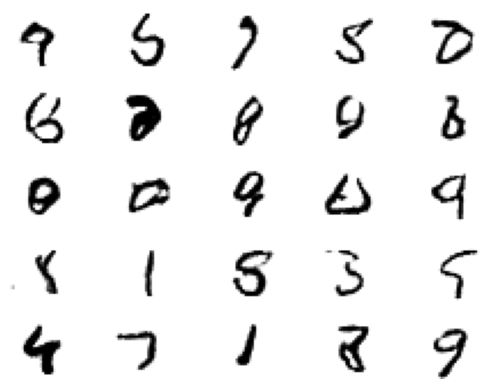

In [16]:
from keras.models import load_model

def save_plot(examples, n):
    #plot images
    for i in range(n*n):
        #define subplot
        plt.subplot(n,n,1+i)
        #turn-off axis
        plt.axis('off')
        #plot raw pixel data
        plt.imshow(examples[i,:,:,0],cmap='gray_r')
    plt.show()
#load model
model=load_model('generator_model_100.h5')
#generate images
latent_points=generate_latent_points(100,25)
#generate images
x=model.predict(latent_points)
#plot the result
save_plot(x,5)

The latent space now defines a compressed representation of MNIST handwritten digits.
You can experiment with generating different points in this space and see what types of numbers
they generate. The example below generates a single handwritten digit using a vector of all 0.0
values.

1/1 [==============================] - 0s 115ms/step


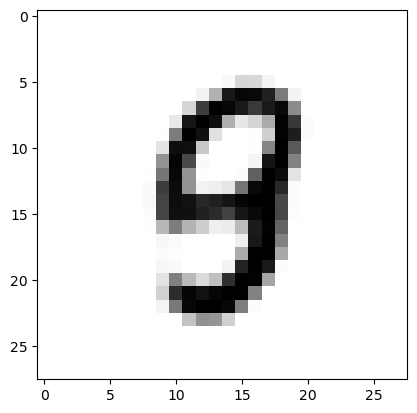

In [17]:
from numpy import asarray
#load model
model=load_model('generator_model_100.h5')
#all 0s
vector=asarray([[0.0 for _ in range(100)]])
#generate image
x=model.predict(vector)
#plot the result
plt.imshow(x[0,:,:,0],cmap='gray_r')
plt.show()